In [ ]:
import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
import re
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [123]:
df = pd.read_csv("data/train_tweets.csv")

## Analyse des valeurs 

In [124]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [126]:
print(df.shape)

(7613, 5)


# Traitement des valeurs nuls ou non pertinentes

In [127]:
df.drop(columns=['id','location'], inplace=True)
df.drop_duplicates(inplace=True)


In [128]:
print(df.shape)

(7541, 3)


In [129]:
df.dropna(inplace=True)
print(df.shape) 
df.info()

(7480, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 7480 entries, 31 to 7582
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   keyword  7480 non-null   object
 1   text     7480 non-null   object
 2   target   7480 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 233.8+ KB


In [130]:
df.head()

,keyword,text,target
31,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,ablaze,We always try to bring the heavy. #metal #RT h...,0
33,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,ablaze,Crying out for more! Set me ablaze,0
35,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [131]:
df['target'].value_counts(normalize=True)

target
0    0.574599
1    0.425401
Name: proportion, dtype: float64

# Proportion target

In [132]:

df_0 = df[df['target'] == 0]
df_1 = df[df['target'] == 1]

# 2. Échantillonner aléatoirement la classe 0 pour avoir autant d'exemples que la classe 1
df_0_sampled = df_0.sample(n=len(df_1), random_state=42)

df_balanced = pd.concat([df_0_sampled, df_1], axis=0).sample(frac=1, random_state=42)  # shuffle le tout


In [133]:

df_balanced['target'].value_counts(normalize=True)

target
1    0.5
0    0.5
Name: proportion, dtype: float64

In [134]:
df_balanced['keyword'].value_counts()


keyword
fatalities               42
outbreak                 39
oil%20spill              38
typhoon                  38
deaths                   37
                         ..
rescue                   18
epicentre                10
radiation%20emergency     9
inundation                9
threat                    9
Name: count, Length: 221, dtype: int64

# Ajout features

In [135]:
# Nombre de caractères par tweet
df_balanced['char_count'] = df_balanced['text'].apply(len)

# Nombre de mots par tweet
df_balanced['word_count'] = df_balanced['text'].apply(lambda x: len(x.split()))

# Statistiques descriptives
df_balanced[['char_count', 'word_count']].describe()


,char_count,word_count
count,6364.000000,6364.000000
mean,102.427876,14.979887
std,32.964656,5.615746
min,7.000000,1.000000
25%,80.000000,11.000000
50%,108.000000,15.000000
75%,134.000000,19.000000
max,157.000000,31.000000


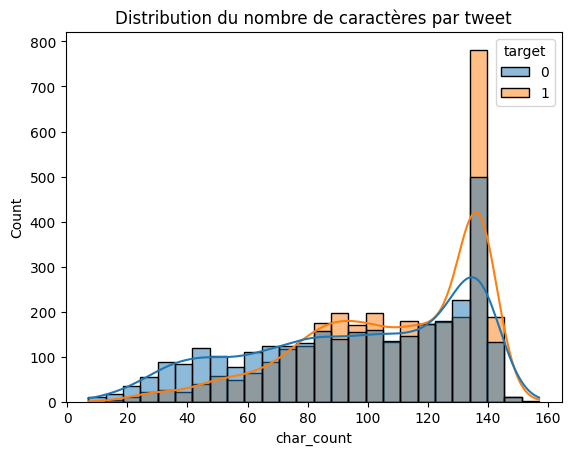

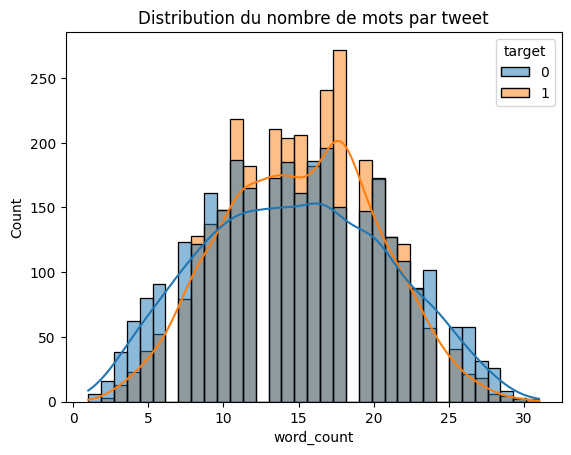

In [136]:


sns.histplot(data=df_balanced, x='char_count', hue='target', kde=True)
plt.title("Distribution du nombre de caractères par tweet")
plt.show()

sns.histplot(data=df_balanced, x='word_count', hue='target', kde=True)
plt.title("Distribution du nombre de mots par tweet")
plt.show()


1. Distribution du nombre de caractères par tweet


La majorité des tweets sont entre 80 et 140 caractères.
Les tweets de catastrophe sont en moyenne plus longs.
Il y a un pic brutal à ~140 caractères pour les deux classes.
Les tweets catastrophes sont surement plus détaillés, plus descriptifs, ce qui donne une longueur moyenne plus élevée.


2. Distribution du nombre de mots par tweet

Les tweets catastrophes contiennent un peu plus de mots que les autres.
Le pic est autour de 14-18 mots pour les catastrophes, un peu plus bas pour les autres.


3. Interprétation globale : 

L’EDA montre que les tweets liés à des catastrophes réelles sont généralement un peu plus longs que les tweets non-catastrophes, à la fois en nombre de caractères et de mots. Cela reflète sans doute leur nature plus factuelle, urgente ou descriptive (ex : rapports d’incidents, alertes, témoignages). Cependant, les distributions restent proches : la longueur seule ne suffit pas à distinguer les classes, mais elle peut constituer un indice utile combiné à d'autres features (mots, n-grammes, keyword, etc.).

# Nettoyage léger pour analyse de texte

Passage en miniscule

In [137]:
df_balanced['text'] = df_balanced['text'].str.lower()
df_balanced['keyword'] = df_balanced['keyword'].str.lower()

In [138]:
df_balanced.head()

,keyword,text,target,char_count,word_count
7335,wildfire,california wildfire destroys more homes but cr...,1,120,13
1271,burned,always look for the silver lining! \n\nmy bar...,0,132,22
7248,weapons,slightly doesn't help that he has suh and wake...,0,138,23
4105,hail,unr issues severe thunderstorm warning [wind: ...,1,137,22
5346,pandemonium,exquisite asian in sto... http://t.co/y9w0v6te...,0,88,11


Suppression des stopwords

In [139]:

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sulivanmoreau/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [140]:

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # minuscules
    text = re.sub(r"http\S+", "", text)  # liens
    text = re.sub(r"@\w+", "", text)     # mentions
    text = re.sub(r"#\w+", "", text)     # hashtags
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # ponctuation/chiffres
    words = text.split()
    words = [w for w in words if w not in stop_words]  # stopwords
    return " ".join(words)

# Nouvelle colonne nettoyée
df_balanced["clean_text"] = df_balanced["text"].apply(clean_text)
df_balanced.drop(columns=['text'], inplace=True)  # Supprimer les colonnes originales


In [141]:
df_balanced.head()

,keyword,target,char_count,word_count,clean_text
7335,wildfire,1,120,13,california wildfire destroys homes crews advan...
1271,burned,0,132,22,always look silver lining barn burned ground s...
7248,weapons,0,138,23,slightly doesnt help suh wake practice think g...
4105,hail,1,137,22,unr issues severe thunderstorm warning wind mp...
5346,pandemonium,0,88,11,exquisite asian sto


In [142]:
df_balanced.head()

,keyword,target,char_count,word_count,clean_text
7335,wildfire,1,120,13,california wildfire destroys homes crews advan...
1271,burned,0,132,22,always look silver lining barn burned ground s...
7248,weapons,0,138,23,slightly doesnt help suh wake practice think g...
4105,hail,1,137,22,unr issues severe thunderstorm warning wind mp...
5346,pandemonium,0,88,11,exquisite asian sto


In [143]:
clean_df_0 = df_balanced[df_balanced['target'] == 0]
clean_df_1 = df_balanced[df_balanced['target'] == 1]

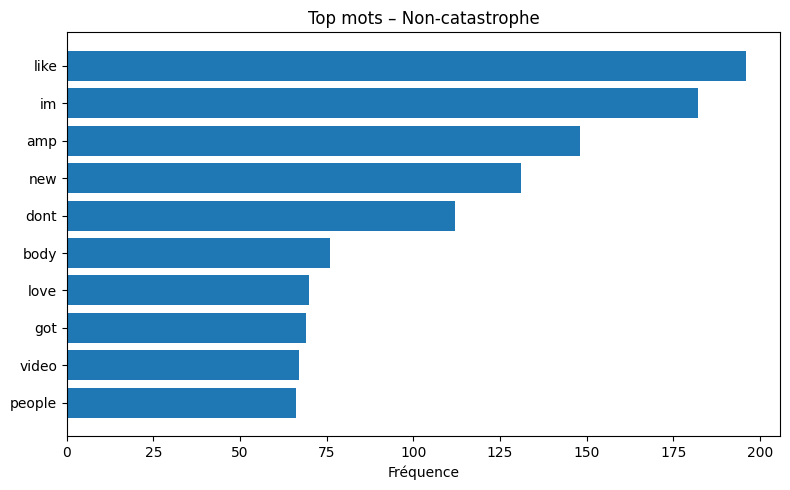

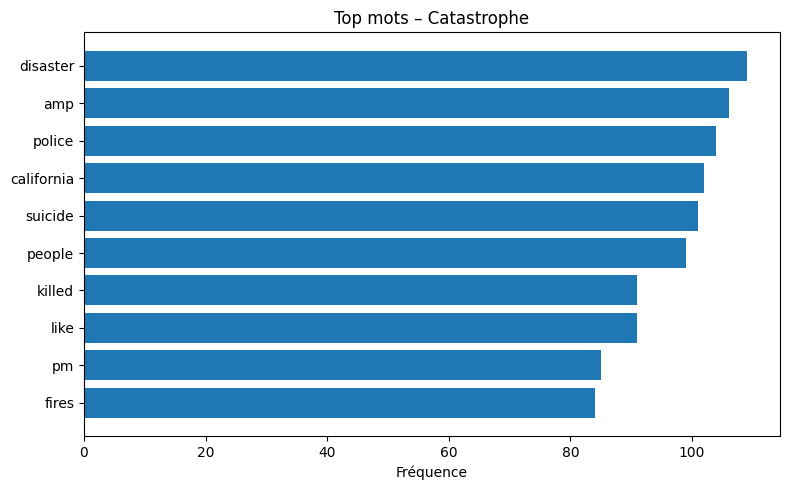

In [144]:
# Fonction pour obtenir les mots les plus fréquents
def get_top_words(series, n=10):
    words = " ".join(series).lower().split()
    words = [w for w in words if w not in ENGLISH_STOP_WORDS]
    return Counter(words).most_common(n)

# Séparation
clean_df_0 = df_balanced[df_balanced['target'] == 0]
clean_df_1 = df_balanced[df_balanced['target'] == 1]

# Top mots
top_words_0 = get_top_words(clean_df_0["clean_text"], 10)
top_words_1 = get_top_words(clean_df_1["clean_text"], 10)

# Barplot
def plot_top_words(word_freq, title):
    words, counts = zip(*word_freq)
    plt.figure(figsize=(8, 5))
    plt.barh(words[::-1], counts[::-1])
    plt.title(title)
    plt.xlabel("Fréquence")
    plt.tight_layout()
    plt.show()

plot_top_words(top_words_0, "Top mots – Non-catastrophe")
plot_top_words(top_words_1, "Top mots – Catastrophe")


In [147]:


# Fonction pour obtenir les mots les plus fréquents
def get_top_words(series, n=10):
    words = " ".join(series).lower().split()
    words = [w for w in words if w not in ENGLISH_STOP_WORDS]
    return Counter(words).most_common(n)

# Séparation des tweets selon la cible
clean_df_0 = df_balanced[df_balanced['target'] == 0]
clean_df_1 = df_balanced[df_balanced['target'] == 1]

# Extraction des top mots
top_words_0 = get_top_words(clean_df_0["clean_text"], 10)
top_words_1 = get_top_words(clean_df_1["clean_text"], 10)

# Tableau combiné
df_top_0 = pd.DataFrame(top_words_0, columns=["Mot (Non-catastrophe)", "Fréquence"])
df_top_1 = pd.DataFrame(top_words_1, columns=["Mot (Catastrophe)", "Fréquence"])
display(pd.concat([df_top_0, df_top_1], axis=1))


,Mot (Non-catastrophe),Fréquence,Mot (Catastrophe),Fréquence
0,like,196,disaster,109
1,im,182,amp,106
2,amp,148,police,104
3,new,131,california,102
4,dont,112,suicide,101
5,body,76,people,99
6,love,70,killed,91
7,got,69,like,91
8,video,67,pm,85
9,people,66,fires,84


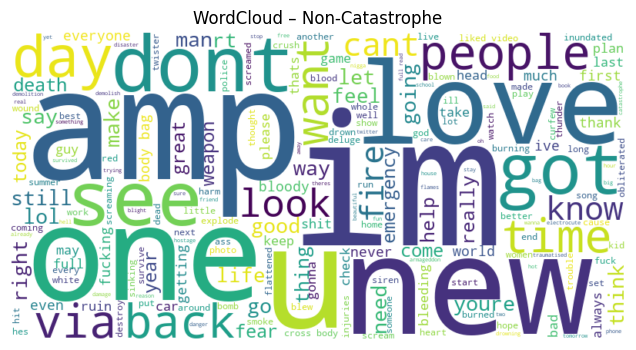

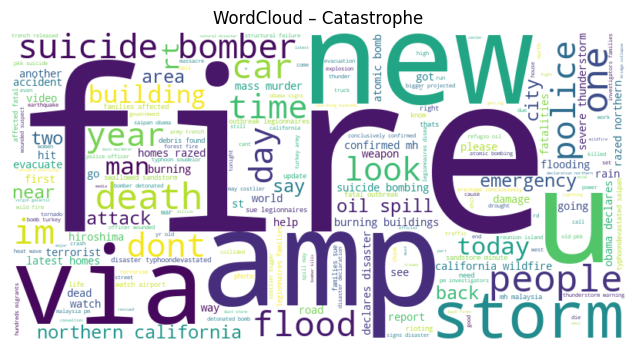

In [150]:



# Concaténer les textes par classe
text_0 = " ".join(clean_df_0["clean_text"])
text_1 = " ".join(clean_df_1["clean_text"])

# Générer les nuages de mots
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(text_0)
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_1)

# Affichage du WordCloud pour target = 0
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Non-Catastrophe")
plt.show()

# Affichage du WordCloud pour target = 1
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Catastrophe")
plt.show()
